In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys

# from degree_days import dds
from tensor_custom_core import *
sys.path.insert(0, '../../aaai18/code/')
import datetime
from sklearn.model_selection import train_test_split, KFold
from common import *
from create_matrix import *
from sklearn.metrics.pairwise import cosine_similarity

import random
from sklearn.cluster import KMeans

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "Austin"
year = 2014

import os

def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [2]:
df, dfc, tensor, static_feature = create_region_df_dfc_static('Austin', 2014, 1, 13)
L = get_L(static_feature)
case = 2
a = 3
b = 3
weight_matrix = np.ones(tensor.shape)
T_constant = np.ones(12).reshape(-1, 1)
tensor_copy = tensor.copy()
H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            L,
                                                          a,
                                                          b, weight_matrix,
                                                          num_iter=3000,
                                                          lr=0.1, dis=True,
                                                          lam=0,
                                                          T_known=T_constant)

498.390915785
140.09512203
101.379737927
88.5219212457
83.0967795185
79.9035478544


In [3]:
from sklearn.cluster import KMeans
# for home factors learnt from aggregate readings
X = H.copy()
X = X/np.max(X)
cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
x1, x2 = (-np.var(X, axis=0)).argsort()[:2]


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


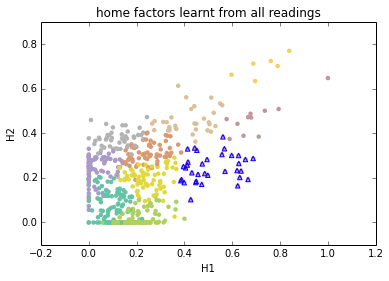

In [4]:
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

start = len(tensor)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[:, x1], X[:, x2], c = cluster, cmap='Set2', lw=0)
plt.xlabel("H1")
plt.ylabel("H2")
plt.title("home factors learnt from all readings")

target_cluster_id = 4
target_cluster_idx = [i for i, j in enumerate(cluster) if j == target_cluster_id]

ax.scatter(X[target_cluster_idx, x1], X[target_cluster_idx, x2], color='blue', marker='^', facecolors='none')



In [5]:
import random
random.seed(10)
random.shuffle(target_cluster_idx)
test_idx = target_cluster_idx[:6]
validate_idx = target_cluster_idx[6:12]

test_validate_idx = np.r_[test_idx, validate_idx]
train_idx = list(set(list(range(533))) - set(test_validate_idx))

In [6]:
train_ix = df.index[train_idx]
test_ix = df.index[test_idx]
validate_ix = df.index[validate_idx]


idx = np.r_[test_ix, validate_ix, train_ix]
df_t = df.loc[idx]
tensor = get_tensor(df_t, 1, 13)
L_inner = L[np.ix_(np.r_[test_validate_idx, train_idx], np.r_[test_validate_idx, train_idx])]

In [7]:
print test_ix
print validate_ix
test_ix = [8589, 499, 2365, 1202, 9295, 9939]
validate_ix = [7117, 6412, 5568, 7951, 4135, 484]

Int64Index([8589, 499, 2365, 1202, 9295, 9939], dtype='int64')
Int64Index([7117, 6412, 5568, 7951, 4135, 484], dtype='int64')


In [8]:
from sklearn.metrics.pairwise import cosine_similarity

num_home_factor = 3
num_season_factor = 3

num_test = len(test_ix)
num_validate = len(validate_ix)
num_train = len(train_ix)

num_iterations = 20

train_df = df.loc[train_ix]
test_validate_df = df.loc[np.r_[test_ix, validate_ix]]

train_tensor = get_tensor(train_df, 1, 13)
test_validate_tensor = get_tensor(test_validate_df, 1, 13)

L_train = L[np.ix_(train_idx, train_idx)]
L_test_validate = L[np.ix_(test_validate_idx, test_validate_idx)]

weight_matrices = {}
train_weight = np.ones(train_tensor.shape)

H = {}
A = {}
T = {}

pred = {}
pred_validation = {}

for iterations in range(num_iterations):
    pred[iterations] = {}
    pred_validation[iterations] = {}
    for appliance in APPLIANCES_ORDER:
        pred[iterations][appliance] = []
        pred_validation[iterations][appliance] = []

tv_weight = np.ones(test_validate_tensor.shape)
print tv_weight.shape

(12, 7, 12)


In [12]:

subset_ix = []
subset_list = {}

for iteration in range(num_iterations):
    
    print 'iteration: ', iteration
    
    stv_df = df.loc[np.r_[subset_ix, test_ix, validate_ix]]
    stv_tensor = get_tensor(stv_df, 1, 13)
    print len(subset_ix)
    num_subset = len(subset_ix)
    
    print '*'*10
    print "num_subset: ", num_subset

    tensor_copy = stv_tensor.copy()
    weight = np.ones(tensor_copy.shape)
    tensor_copy[num_subset:(num_subset + num_test), 1:, :] = np.NaN
    H_tv, A_tv, T_tv, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy, 
                                                                        0, num_home_factor,
                                                                       num_season_factor, weight, num_iter=3000,
                                                                       lr=0.1, dis=True, lam=0, T_known=T_constant)

    HAT = multiply_case(H_tv, A_tv, T_tv, 2)
    for appliance in APPLIANCES_ORDER:
        pred[iteration][appliance].append(pd.DataFrame(HAT[num_subset:(num_subset + num_test), appliance_index[appliance], :], index = test_ix))
        pred_validation[iteration][appliance].append(pd.DataFrame(HAT[(num_subset + num_test):, appliance_index[appliance], :], index = validate_ix))
        
    tensor_copy = train_tensor.copy()
    weight = np.ones(tensor_copy.shape)
    H_tr, A_tr, T_tr, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                                       L_train, num_home_factor,num_season_factor,
                                                                       weight, num_iter=3000, lr=0.1, dis=True, lam=0, 
                                                                       A_known=A_tv, T_known=T_tv)

    pred_train = {}
    error = {}
    for appliance in APPLIANCES_ORDER[1:]:
        pred_train[appliance] = []

    HAT = multiply_case(H_tr, A_tr, T_tr, 2)
    for appliance in APPLIANCES_ORDER[1:]:
        pred_train[appliance].append(pd.DataFrame(HAT[:, appliance_index[appliance], :], index = train_ix))

    # compute the appliance prediction error for each validation homes
    for appliance in APPLIANCES_ORDER[1:]:
        s = pd.concat(pred_train[appliance]).loc[train_ix]
        if appliance=="hvac":
            error[appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[3]
        else:   
            error[appliance] = compute_rmse_fraction(appliance, s, 'Austin')[3]


    # compute the average appliance error for each home
    error_avg = {}
    for appliance in APPLIANCES_ORDER[1:]:

        if appliance == 'hvac':
            start, end = 5, 11
        else:
            start, end = 1, 13

        error_home = pd.concat([error[appliance][appliance + "_{}".format(start)], 
                           error[appliance][appliance + "_{}".format(start+1)]],axis=1)

        for i in range(start+2, end):
            error_home = pd.concat([error_home, error[appliance][appliance + "_{}".format(i)]], axis=1)
        app = np.sqrt((error_home**2).mean(axis=1))
        error_avg[appliance] = app
    error_overall = (pd.DataFrame(error_avg).fillna(0)*pd.Series(contri['Austin'])).sum(axis=1)
    print num_train
    subset_ix = error_overall.nsmallest(25).index
    H[iteration] = H_tv
    subset_list[iteration] = subset_ix
#     subset_ix = train_ix

iteration:  0
0
**********
num_subset:  0
700.909030002
106.516943338
93.3049278776
90.9119360126
89.2823417431
88.2845839196
445.628122717
188.73108368
142.000025024
122.378585947
111.949730122
105.558811584
521
iteration:  1
25
**********
num_subset:  25
585.294262552
107.60338914
93.7933564735
92.6803550079
91.9176260898
91.3253207693
445.305992558
189.699129052
144.411365737
125.518950014
115.414783398
109.130896212
521
iteration:  2
25
**********
num_subset:  25
516.476522343
95.9521897918
83.9840440917
82.7347306097
81.8765425822
81.2153044716
446.14029696
191.722642552
145.108688697
125.38272283
114.786900079
108.197665774
521
iteration:  3
25
**********
num_subset:  25
511.265251049
93.4411266106
82.3331110818
81.115868879
80.2654643916
79.625021213
445.841811315
191.133189481
145.058159641
125.654002079
115.242887971
108.770458313
521
iteration:  4
25
**********
num_subset:  25
516.643463113
94.5126237265
83.2227973164
82.0076888317
81.1513768741
80.4905855669
445.890760143
19

In [17]:
set(subset_list[0]).intersection(set(subset_list[19]))

{1800,
 2075,
 2360,
 3310,
 4193,
 4213,
 4544,
 5298,
 5403,
 6324,
 6460,
 7013,
 7361,
 7468,
 8059,
 8117,
 8328,
 8736,
 8848}

### Home factors and weights

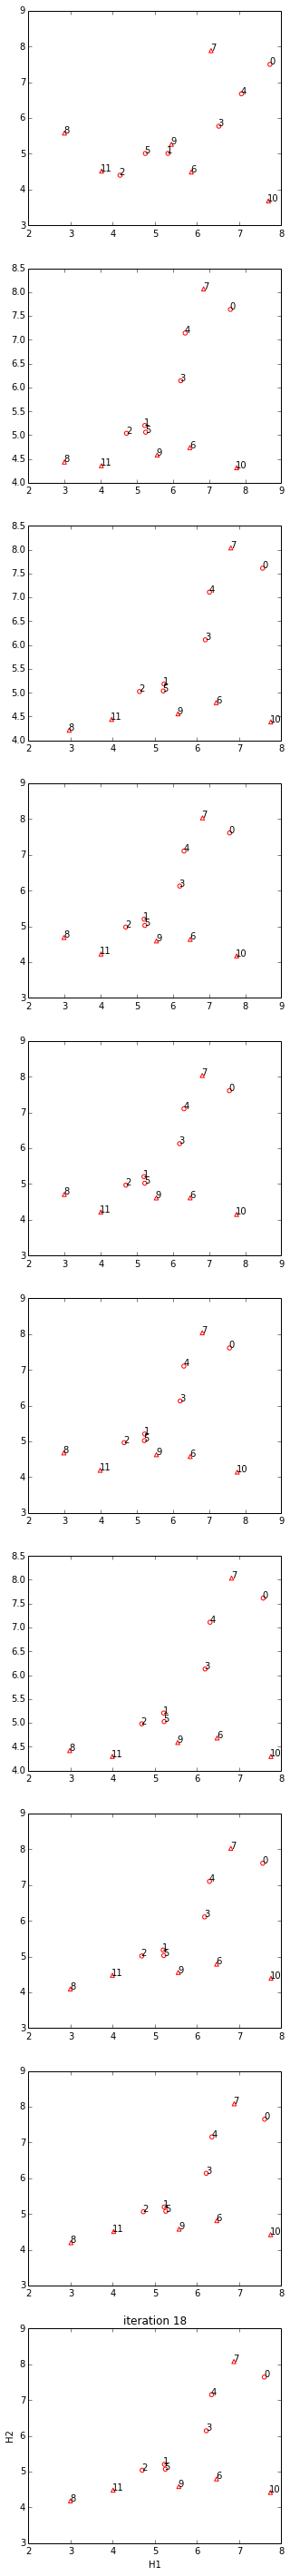

In [15]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(5, 50))


for iteration in range(0, num_iterations, 2):
    X = H[iteration][-(num_test +num_validate):]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    x1, x2 = (-np.var(X, axis=0)).argsort()[:2]
   
    
#     train_sim = weight_matrices[method][iteration][:].mean(axis=1).mean(axis=1)
#     axes[iteration/2].scatter(X[:, x1], X[:, x2], cmap='Blues', lw=0)
    axes[iteration/2].scatter(X[:num_test, x1], X[:num_test, x2], color='red', marker='o', facecolors='none')
    axes[iteration/2].scatter(X[num_test:(num_test+num_validate), x1], X[num_test:(num_test+num_validate), x2], color='red', marker='^', facecolors='none')
    for i in range(len(X)):
        axes[iteration/2].annotate(i, (X[i, x1],X[i, x2]), color='black')
    plt.xlabel("H1")
    plt.ylabel("H2")
    plt.title('iteration {}'.format(iteration))


### test homes

In [16]:
out= {}

for iteration in range(num_iterations):
    print  iteration
    out[iteration] = {}
    for appliance in APPLIANCES_ORDER[1:]:
        s = pd.concat(pred[iteration][appliance]).loc[test_ix]
        print appliance
        try:
            if appliance=="hvac":
                out[iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[2]
            else:   
                out[iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[2]
        except Exception, e:
            print (e)

0
hvac
fridge
mw
dw
wm
oven
1
hvac
fridge
mw
dw
wm
oven
2
hvac
fridge
mw
dw
wm
oven
3
hvac
fridge
mw
dw
wm
oven
4
hvac
fridge
mw
dw
wm
oven
5
hvac
fridge
mw
dw
wm
oven
6
hvac
fridge
mw
dw
wm
oven
7
hvac
fridge
mw
dw
wm
oven
8
hvac
fridge
mw
dw
wm
oven
9
hvac
fridge
mw
dw
wm
oven
10
hvac
fridge
mw
dw
wm
oven
11
hvac
fridge
mw
dw
wm
oven
12
hvac
fridge
mw
dw
wm
oven
13
hvac
fridge
mw
dw
wm
oven
14
hvac
fridge
mw
dw
wm
oven
15
hvac
fridge
mw
dw
wm
oven
16
hvac
fridge
mw
dw
wm
oven
17
hvac
fridge
mw
dw
wm
oven
18
hvac
fridge
mw
dw
wm
oven
19
hvac
fridge
mw
dw
wm
oven


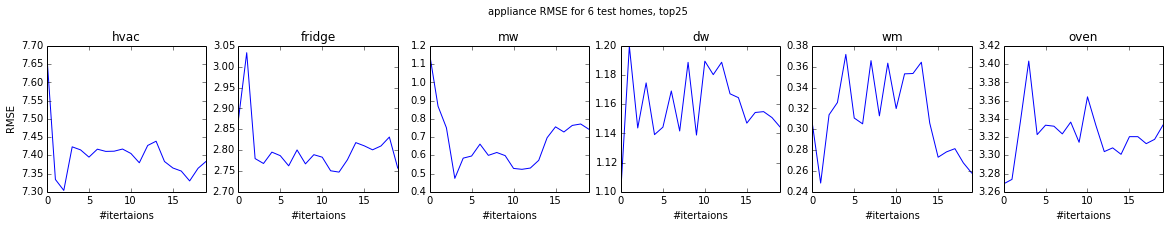

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,3))
ax = axes.flatten()
count = 0
mean_out = pd.DataFrame(out)
       
for appliance in APPLIANCES_ORDER[1:]:
#     mean_out_v['same']['max'].T[appliance].plot(ax = ax[count], title=appliance)
    mean_out.T[appliance].plot(ax = ax[count], title=appliance)

#     mean_out_v['diff']['max'].T[appliance].plot(ax = ax[count], title=appliance)
#     mean_out_v['diff']['min'].T[appliance].plot(ax = ax[count], title=appliance)
    
    ax[count].set_xlabel("#itertaions")
    count += 1
ax[0].set_ylabel("RMSE")
# ax[count-1].legend(['independent', 'jointly'], loc='center left')
plt.suptitle("appliance RMSE for 6 test homes, top25")
fig.subplots_adjust(top=0.8)
plt.savefig("appliance-RMSE_test_select_train_top25.pdf", format='pdf')

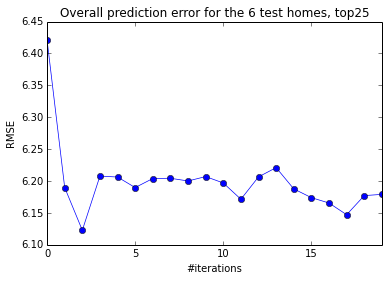

In [19]:
fig, ax = plt.subplots()
error = {}
error = (mean_out.T*pd.Series(contri['Austin'])).sum(axis=1)
error.plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['b'])


ax.set_xlabel("#iterations")
ax.set_ylabel("RMSE")
ax.set_title("Overall prediction error for the 6 test homes, top25")

plt.savefig("overall-RMSE_test_select_train_top25.pdf", format='pdf')